<a href="https://colab.research.google.com/github/EttaChr/bitnami/blob/main/CNN_riconoscimento_figure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#libreria per leggere e scrivere dati su Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Importo tutte le librerie che mi serviranno per il programma

In [ ]:
#librerie per CNN e manipolazione delle immagini
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import imutils
import math
import argparse

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from google.colab import drive
from google.colab.patches import cv2_imshow
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

#librerie per il generatore di immagini
import random
import shutil
from PIL import Image as IMG, ImageDraw

In [ ]:
#directory del progetto su google drive

base_dir = '/gdrive/My Drive/Colab Notebooks/Progetto Principi e modelli della percezione/'
ROOT_DIR = "/content/"

Dichiaro le funzioni che mi servono per generare random i Rettangoli e i Triangoli di Kanizsa

In [ ]:
#funzioni per la generazione randomica di Triangoli e Quadrati di Kanizsa

#funzione per generare area del cerchio spezzato
def makeCircleArea(x, y, raggio):
    return [(x - raggio, y - raggio), (x + raggio, y + raggio)]

#funzione per generare dei punti di rettangolo random
def generateRandomRectPoint(w, h, r, offset=10):
    raggio = int(r / 2) + offset
    x = [
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(int(w / 2) + raggio, w - raggio),
        random.randint(int(w / 2) + raggio, w - raggio)
    ]
    y = [
        random.randint(raggio, int(h / 2) - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(raggio, int(h / 2) - raggio),
    ]

    return [
        # angolo in alto a sinistra
        [x[0], y[0]],
        # angolo in basso a sinistra
        [x[1], y[1]],
        # angolo in basso a destra
        [x[2], y[2]],
        # angolo in alto a destra
        [x[3], y[3]]
    ]


def generateRandomTrianglePoint(w, h, r, offset=10):
    raggio = int(r / 2) + offset
    x = [
        random.randint(int(w / 4), int(w * 3 / 4)),
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(int(w / 2) + raggio, w - raggio)
    ]
    y = [
        random.randint(int(raggio + 1), int(h / 2) - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(int(h / 2) + raggio, h - raggio)
    ]

    return [
        # metà superiore, centrato
        [x[0], y[0]],
        # angolo in basso a sinistra
        [x[1], y[1]],
        # angolo in basso a destra
        [x[2], y[2]]
    ]

#funzione che disegna effettivamente il rettangolo di kanizsa
def drawNKanizsaRect(n, w, h, dir):

    path = os.path.join(dir,'rect/')

    os.mkdir(path)

    for i in range(n):
        shape = [(0, 0), (w, h)]

        img = IMG.new("RGB", (w, h))

        imgD = ImageDraw.Draw(img)
        imgD.rectangle(shape, fill="#FFF")

        raggio = 20
        fill = "#000"

        punti = generateRandomRectPoint(w, h, raggio)
        poly = []

        for p in punti:
            #disegna un'ellisse all'interno del rettangolo di selezione specificato
            imgD.ellipse(makeCircleArea(p[0], p[1], raggio), fill)
            poly.append((p[0], p[1]))

        #disegna un poligono con i punti dei poli
        imgD.polygon(poly, fill="#fff")

        img.save(os.path.join(path,  i.__str__() + ".png"))

    return

#funzione che disegna effettivamente il triangolo di kanizsa
def drawNKanizsaTriangle(n, w, h, dir):

    path = os.path.join(dir,'triangle/')


    os.mkdir(path)

    for i in range(n):
        shape = [(0, 0), (w, h)]

        img = IMG.new("RGB", (w, h))

        imgD = ImageDraw.Draw(img)
        imgD.rectangle(shape, fill="#FFF")

        raggio = 20
        fill = "#000"

        punti = generateRandomTrianglePoint(w, h, raggio)
        poly = []

        for p in punti:
            #disegna un'ellisse all'interno del rettangolo di selezione specificato
            imgD.ellipse(makeCircleArea(p[0], p[1], raggio), fill)
            poly.append((p[0], p[1]))

        #disegna un poligono con i punti dei poli
        imgD.polygon(poly, fill="#fff")
        img.save(os.path.join(path,  i.__str__() + ".png"))


    return

Inizio del programma che prende in input il numero di immagini di training e genera tramite le funzioni dichiarate prima i Trinagoli e Rettangoli di Kanizsa per il training

In [ ]:
w, h = 200, 200
n = input("Insert number of images for training: ")
n = int(n)

dir = os.path.join(ROOT_DIR, "training/")

if os.path.isdir(dir):
  shutil.rmtree(dir)

os.mkdir(dir)

print(dir)

drawNKanizsaTriangle(n, w, h,dir)
print(n.__str__() + " Triangle for -training- generated")
drawNKanizsaRect(n, w, h,dir)
print(n.__str__() + " Rectangle for -training- generated")


n = input("Insert number of images for validation: ")
n = int(n)

dir = os.path.join(ROOT_DIR, "validation/")

if os.path.isdir(dir):
  shutil.rmtree(dir)

os.mkdir(dir)

print(dir)

drawNKanizsaTriangle(n, w, h,dir)
print(n.__str__() + " Triangle for -validation- generated")
drawNKanizsaRect(n, w, h,dir)
print(n.__str__() + " Rectangle for -validation- generated")

Insert number of images for training: 6
/content/training/
6 Triangle for -training- generated
6 Rectangle for -training- generated
Insert number of images for validation: 6
/content/validation/
6 Triangle for -validation- generated
6 Rectangle for -validation- generated


Creo il set dei dati con i dati precedentemente generati di training e validazione

In [ ]:
#Creazione del set dati con i dati di training e validazione
batch_size = 50
img_height = 200
img_width = 200

data_dir= '/content/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 12 files belonging to 2 classes.
Using 10 files for training.
Found 12 files belonging to 2 classes.
Using 2 files for validation.
['rect', 'triangle']


Faccio un test e visualizzo i dati raccolti e generati fino ad ora

test training images


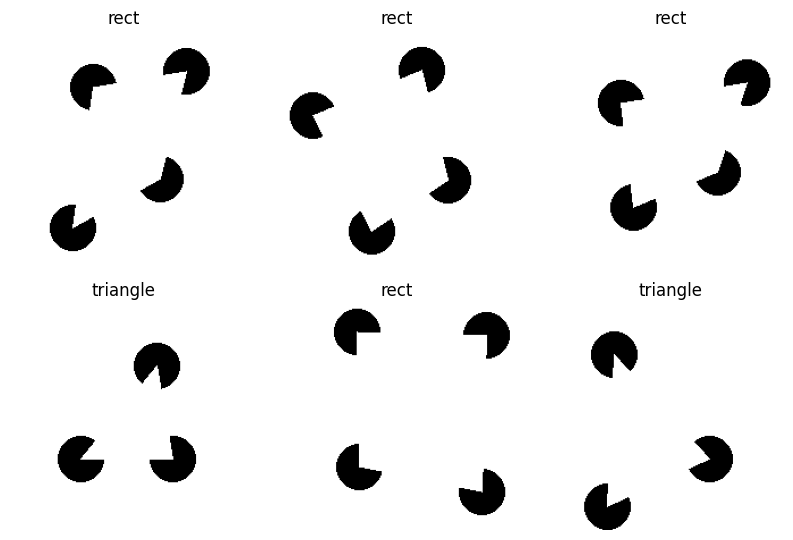

In [ ]:
# test visualizzazione dei dati di train e validation
print("test training images")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#print("test validation images")
#plt.figure(figsize=(10, 10))
#for images, labels in val_ds.take(1):
#  for i in range(6):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

Configuro e salvo in cache il set di dati così da evitare eventuali blocchi che possono essere causati dall'I/O da disco

In [ ]:
#configura il set di dati per le prestazioni
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardizziamo i dati in modo che siano leggibili per la rete neurale, trasforma i valori dei pixel in 0 e 1 per evitare che la rete debba leggere 255 valori differenti.
Dopodichè possiamo notare che adesso i valori dei pixel sono compresi nell'intervallo [0,1] e stampiamo quindi il valore minimo e massimo

In [ ]:
#standardizziamo i dati
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#valori dei pixel in [0,1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


Creiamo e poi compoiliamo il nostro modello di Rete Neurale

In [ ]:
#creazione del modello di rete neurale
num_classes = len(class_names)
print(num_classes)

model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

2


In [ ]:
#compilazione del modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 200, 200, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,143,970 (19.62 MB)

 Trainable params: 5,143,970 (19.62 MB)

 Non-trainable params: 0 (0.00 B)

Questo sopra è il nostro modello compilato con riportati i numeri dei parametri addestrabili.

Qui di seguito invece iniziamo la fase di trading definendo il numero di epochs, ossia il numero di volte che il nostro algoritmo di apprendimento funzionerà attraverso l'intero set di dati di addestramento.

In [ ]:
#training del modello

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 3.6037
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.5000 - loss: 3.1960 - val_accuracy: 0.5000 - val_loss: 2.0259
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5000 - loss: 1.7529 - val_accuracy: 0.5000 - val_loss: 1.5909
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - accuracy: 0.5000 - loss: 1.2138 - val_accuracy: 0.5000 - val_loss: 0.7412
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3898 - val_accuracy: 0.5000 - val_loss: 0.7718
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.4600 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9000 - loss: 0.3357 - val_accuracy: 1.0000 - val_loss: 0.6168
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - accuracy: 1.0000 - loss: 0.1932 - val_accuracy: 0.5000 - val_loss: 0.7218
E

Andiamo ora ad analizzare l'accuratezza del nostro modello e visualizziamo i grafici

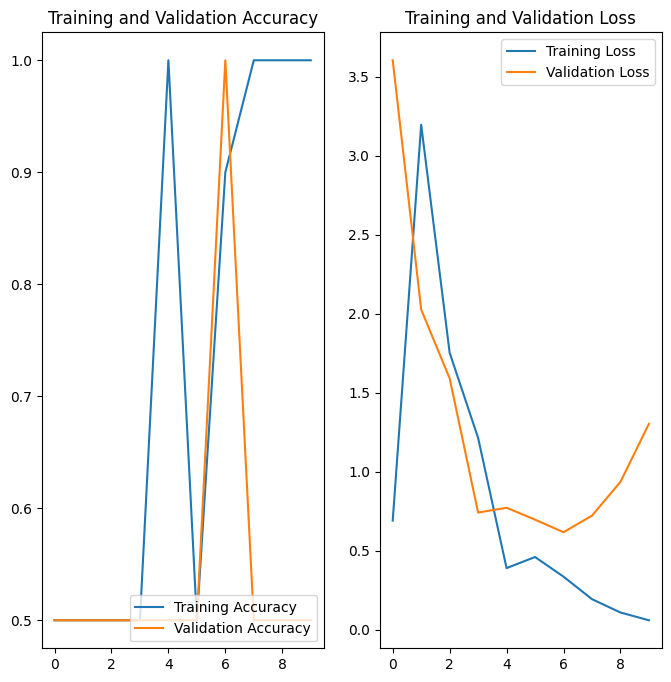

In [ ]:
# Analizziamo accuratezza modello

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#visualizzazione grafici Accuracy e Loss

In [ ]:
#salviamo il modello
os.makedirs(os.path.dirname(base_dir+ 'CNN saved models/4000_sample.keras'), exist_ok=True)
model.save(base_dir +'CNN saved models/4000_sample.keras')

In [ ]:
# codice per disegnare triangoli e rettangoli di Kanizsa
canvas_html = """
<canvas id="c" width="%d" height="%d"></canvas>
<button>Save</button>
<script>
var c = document.getElementById('c')
var ctx = c.getContext("2d")
var mouse = {x:0, y:0}
var punti = [];
var button = document.querySelector('button')
var raggio = %d
ctx.fillStyle = "#000"
ctx.lineWidth = %d
white();

c.addEventListener("mousemove", e =>{
   var rect = c.getBoundingClientRect();
   mouse.x = e.clientX - rect.left
   mouse.y = e.clientY - rect.top
})

c.addEventListener("click", e =>{
   if(punti.length < 4){
    punti.push({x:mouse.x,y:mouse.y})
    white();
    drawPunti();
    drawPolygon();
   }
})

function drawPunti(){
  for(let p of punti){
    ctx.beginPath()
    ctx.fillStyle = "#000"
    ctx.ellipse(p.x,p.y, raggio, raggio , 0, 0, 2*Math.PI)
    ctx.fill()
    ctx.closePath()
  }
}

function drawPolygon(){
  if(punti.length == 0) return

  ctx.moveTo(punti[0].x, punti[0].y)
  ctx.fillStyle = '#fff';
  ctx.beginPath();
  for(let p of punti){
      ctx.lineTo(p.x, p.y);
  }
  ctx.closePath();
  ctx.fill();
  ctx.fillStyle = '#000';
}

function white(){
  ctx.fillStyle="#fff"
  ctx.beginPath()
  ctx.fillRect(0,0, 1000,1000)
  ctx.closePath()
  ctx.fillStyle="#000"
}

function stop(){
    white();
    drawPunti();
    drawPolygon();
}

window.data = new Promise(resolve=>{
  button.onclick = ()=>{
    stop();
    resolve(c.toDataURL('image/png'))
  }
})
</script>

"""

def draw(filename='drawing.png', w=400, h=400, raggio = 40, line_width=1):
  filename = os.path.join(ROOT_DIR,  filename)
  display(HTML(canvas_html % (w, h, raggio , line_width)))
  print("Please click the 'Save' button to continue")
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
    print("saved")
  return len(binary)


print("Inserisci da 3 a 4 punti in senso orario o antiorario")
draw();

Inserisci da 3 a 4 punti in senso orario o antiorario


Please click the 'Save' button to continue
saved


Ora andiamo a caricare il modello di training precedentemente salvato.
Iniziamo poi la predizione dell'immagine appena disegnata.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
This image most likely belongs to triangle with a 58.78 percent confidence.


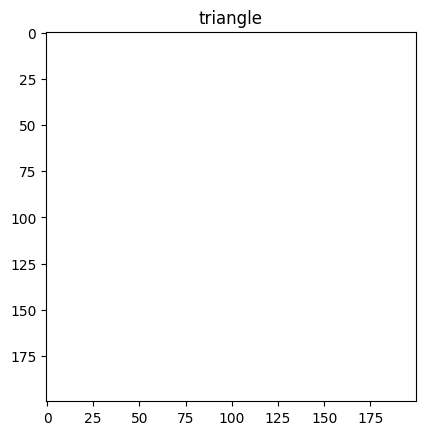

In [ ]:
#predizione con nuova immagine

model= tf.keras.models.load_model(base_dir +'CNN saved models/4000_sample.keras')

test_image_path = ROOT_DIR + "drawing.png"

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Crea una batch di immagini nel caso in cui gli vengano passate più immagini

#prediciamo l'immagine appena salvata
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.title(class_names[np.argmax(score)])

#tramite la predizione e il punteggio ottenuto, il programma andrà a scegliere tra una delle due classi quale si avvicina di più all'immagine visualizzata e con quale precisione

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Andiamo ora ad analizzare l'immagine appena predetta tramite la classe Analyzer con tutte le sue funzioni

In [ ]:
# classe contente tutto il necessario per analizzare l'immagine
class Analyzer:

    def __init__(self, original_image):
        self.original = original_image
        self.image = self.copyOriginal()

    def copyOriginal(self):
        return self.original.copy()

    def makeNegative(self, image):
        return cv2.bitwise_not(image)

    def makeGrayScale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def blurImage(self, image):
      image = image.copy()
      return cv2.GaussianBlur(image, (5, 5), 0)

    def makeTresh(self, image):
      image = image.copy()
      return cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)[1]

    def canny(self, image):
        return cv2.Canny(image, 0, 50)

    def getShapeMask(self, image):
        lower = np.array([0, 0, 0])
        upper = np.array([15, 15, 15])
        return cv2.inRange(image, lower, upper)

    def makeHoughLines(self, canny):
        return cv2.HoughLines(canny, 1, np.pi / 180, 32, None, 0, 0) # 32

    def makeProbHoughLines(self,canny):
        return cv2.HoughLinesP(canny, 1,np.pi/180,35,None,100,400) # 35

    def findShapes(self, image):
        contours = cv2.findContours(self.getShapeMask(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return imutils.grab_contours(contours)

    def getNumberOfShapes(self, image):
        return len(self.findShapes(image))

    def drawLines(self, image, hLines):
        image = image.copy()
        counter = 0
        n_shape = self.getNumberOfShapes(image)
        if hLines is not None:
          for i in range(0, len(hLines)):
              rho = hLines[i][0][0]
              theta = hLines[i][0][1]
              a = math.cos(theta)
              b = math.sin(theta)
              x0 = a * rho
              y0 = b * rho
              pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
              pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
              cv2.line(image, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)

        return image

    def drawProbLines(self,image,pLines):
      image = image.copy()
      img = IMG.new("RGB", (400,400))

      imgD = ImageDraw.Draw(img)
      imgD.rectangle([(0, 0), (400, 400)], fill="#FFF")
      img = np.array(img)

      if pLines is not None:
        for i in range(0, len(pLines)):
            l = pLines[i][0]
            cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv2.LINE_AA)
            cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,0,0), 2, cv2.LINE_AA)


      return (image, img)

    def showImage(self, image, wait=False):
        cv2_imshow(image)
        if wait:
            cv2.waitKey(0)

    def plotOfCanny(self, image, canny):

        plt.subplot(121), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(canny, cmap='gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
        plt.show()

Partendo dall'immagine originale creiamo un oggetto che mi vada ad analizzare l'immagine.
Andiamo a trasformare l'immagine in negativo per migliorare l'analisi (qui sotto mostrata)
Utilizziamo l'algoritmo Canny (il più famoso tra gli algoritmi di edge detection) che prende in ingresso un'immagine in scala di grigi e ne produce una che fa risaltare la posizione dei bordi

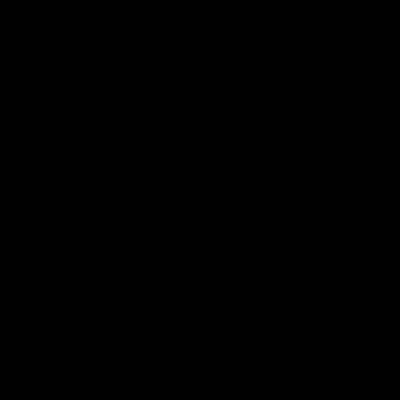

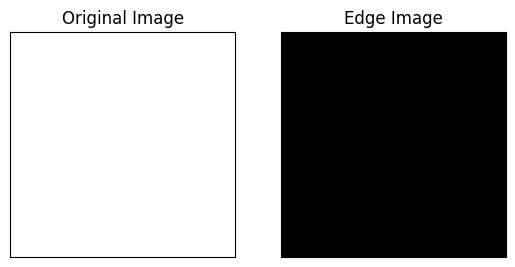

In [ ]:
original = cv2.imread('/content/drawing.png')

# creo oggetto analizzatore
an = Analyzer(original)

negative = an.makeNegative(an.copyOriginal())  # negativo per migliorare l'analisi
an.showImage(negative)
canny = an.canny(negative)  # canny per trovare i punti
an.plotOfCanny(an.copyOriginal(), canny)

Tracciamo ora delle linee (HoughLines) nei punti di interesse dei bordi ricavati dall'algoritmo Canny
Tracciamo anche le linee HoghLines di tipo probabilistico
Salviamo l'immagine con le linee appena prodotte e visualizziamo tutte le immagini appena generate con le HoughLines

--- HougLines ---


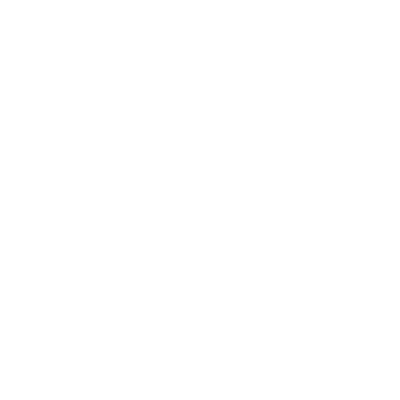

--- HougLines Probabilistico ---


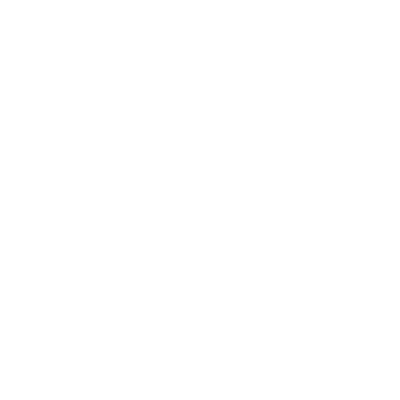

--- Solo linee ---


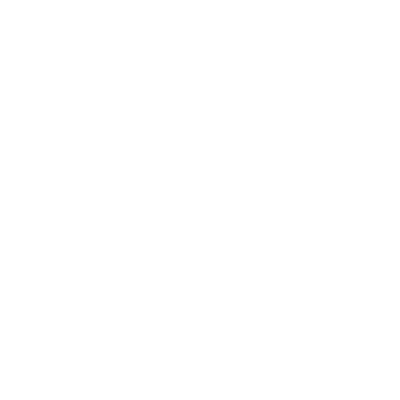

In [ ]:
hLines = an.makeHoughLines(canny)
linesImage = an.drawLines(an.copyOriginal(), hLines=hLines)
print("--- HougLines ---")
an.showImage(linesImage)
cv2.imwrite('/content/output.png',linesImage)

pLines = an.makeProbHoughLines(canny)
probImage, onlyLines = an.drawProbLines(an.copyOriginal(), pLines=pLines)
print("--- HougLines Probabilistico ---")
an.showImage(probImage)
print("--- Solo linee ---")
an.showImage(onlyLines)

Grazie alla classe Shape Detector e ai suoi metodi possiamo determinare con il grado di approssimazione dei poli se la forma è un triangolo o un rettangolo.

Partendo dall'immagine Solo linee deriviamo le immagini in negativo, scala di grigi, sfocata e tresh. Dopo vengono determinati i contorni grazie all'immagine tresh. Infine viene ridisegnata, riempita e immesso il testo della forma corrispondente.

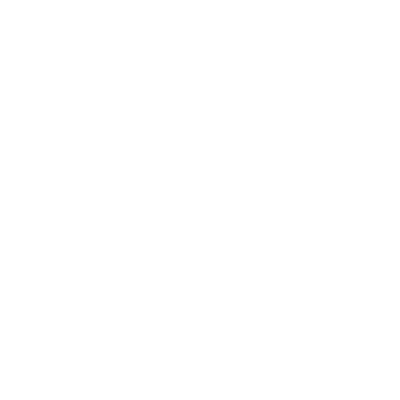

In [ ]:
class ShapeDetector:

  def detect(self, c):
    shape = "unidentified"
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c, 0.04*peri, True)

    if(len(approx) == 3):
      shape = "triangle"
    elif(len(approx) == 4):
      shape = "rectangle"


    return shape;



image = onlyLines.copy()
negative = an.makeNegative(image)
gray = an.makeGrayScale(negative)
blur = an.blurImage(gray)
tresh = an.makeTresh(blur)


contour = cv2.findContours(tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = imutils.grab_contours(contour)
sd = ShapeDetector()

for c in contour:
  M = cv2.moments(c)

  cX = int((M["m10"] / M["m00"]))
  cY = int((M["m01"] / M["m00"]))
  shape = sd.detect(c)
  cv2.fillPoly(image, [c], (0,215,255))
  cv2.drawContours(image, [c], -1, (0, 255, 0), 8)
  cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
		0.5, (0, 0, 0), 2)
  print("The shape is: ",shape)

an.showImage(image)